Vector 3D class 

In [1]:
class Vector3D:
    def __init__(self, x, y, z):
        self.x = x
        self.y = y
        self.z = z

    def __sub__(self, other):
       return Vector3D(self.x - other.x, self.y - other.y, self.z - other.z)

    def dot(self, other):
        return self.x * other.x + self.y * other.y + self.z * other.z

    def cross(self, other):
        ax = self.y * other.z - self.z * other.y
        by = self.z * other.x - self.x * other.z
        cz = self.x * other.y - self.y * other.x
        return Vector3D(ax, by, cz)

    def magnitude(self):
        return (self.x**2 + self.y**2 + self.z**2)**0.5

    def normalize(self):
        mag = self.magnitude()
        if mag == 0:
            raise ValueError("Cannot normalize a zero vector.")
        return Vector3D(self.x / mag, self.y / mag, self.z / mag)

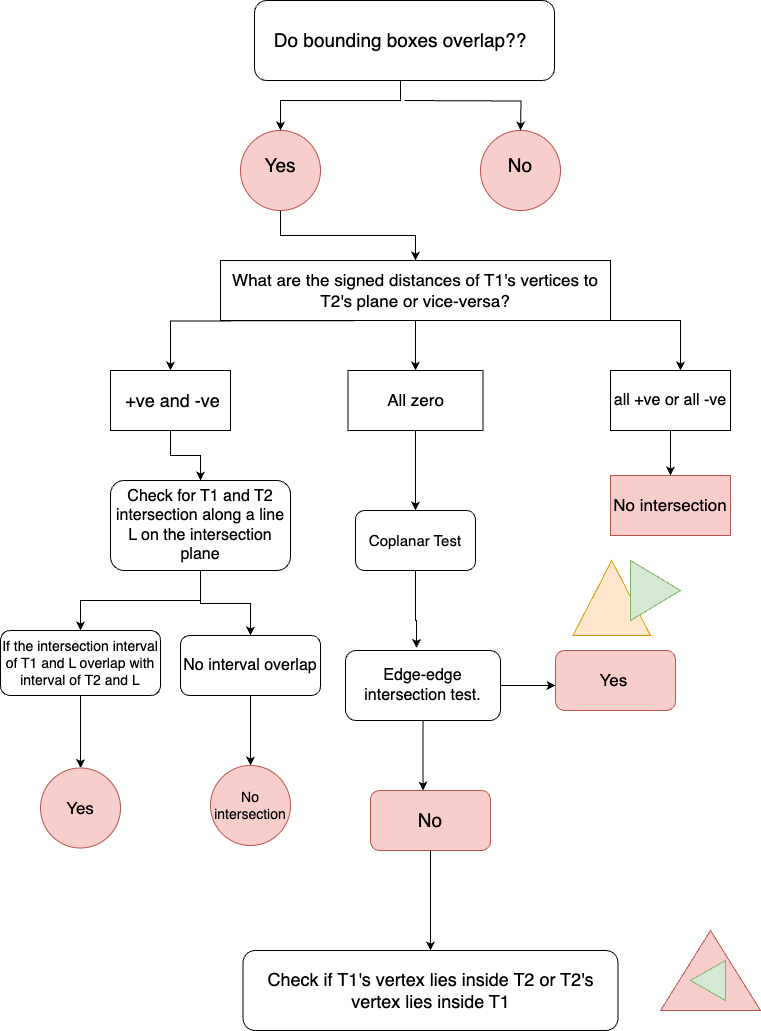

In [47]:
from IPython.display import Image, display

# Replace with the path to your image
image_path = "/Users/kriti/Downloads/Intersection_diagram_f.drawio.png"
display(Image(filename=image_path,width=500))

Non-coplanar triangle intersection test

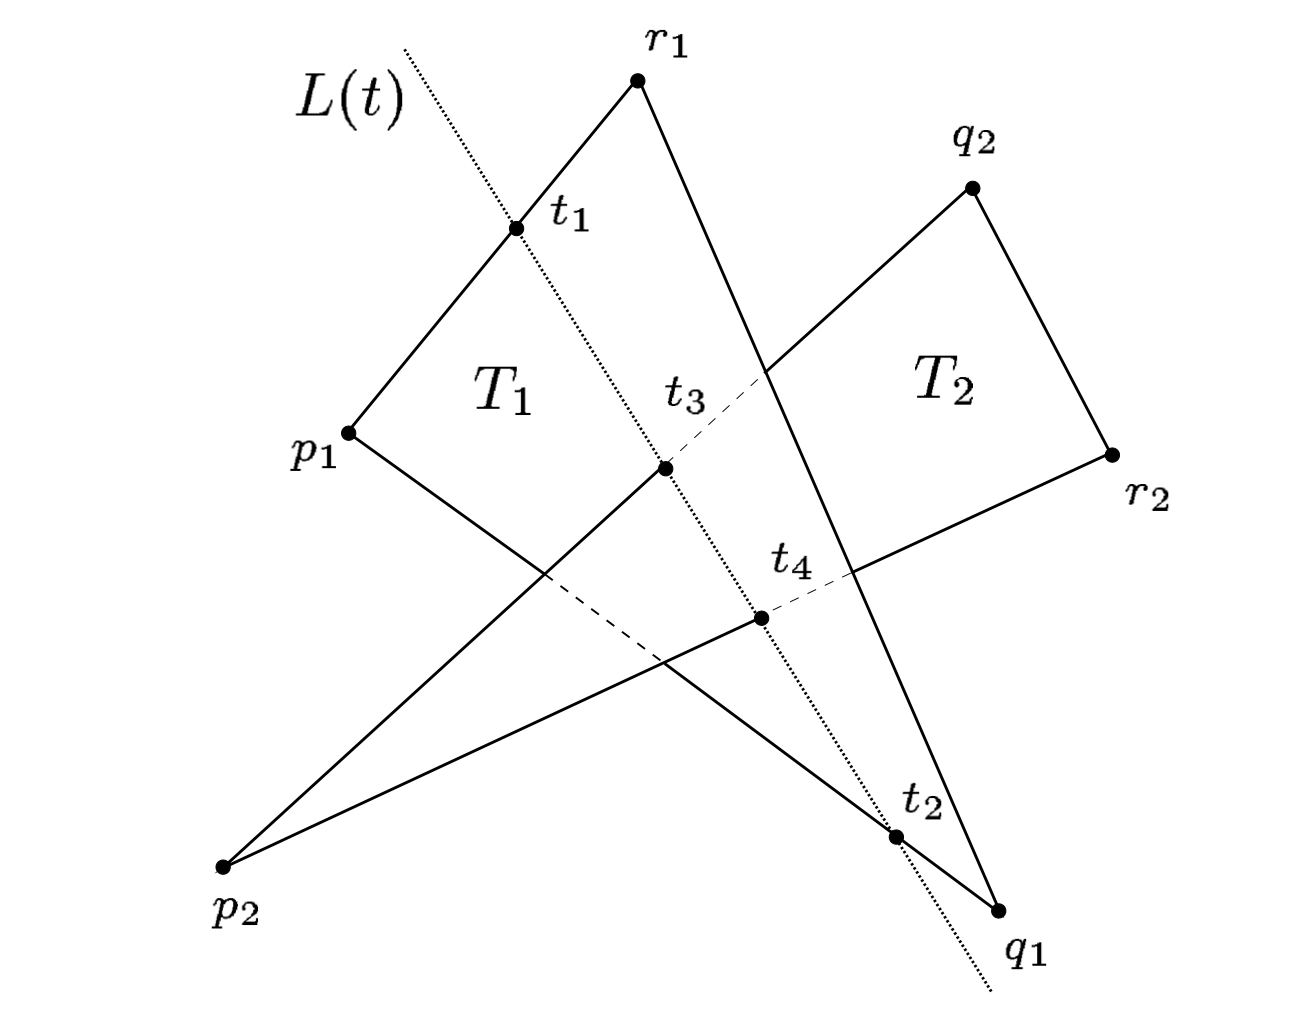

In [46]:
from IPython.display import Image, display

# Replace with the path to your image
image_path = "/Users/kriti/Downloads/triangle_intersection_line_overlap.png"
display(Image(filename=image_path,width=300))

In [37]:
import numpy as np

class Triangle:
    def __init__(self, p1, p2, p3):
        """
        Initialize the triangle with three points (Vector3D instances).
        """
        self.p1 = p1
        self.p2 = p2
        self.p3 = p3

    def area(self):
        """
        Calculate the area of the triangle using the cross product.  Area of a triangle in 3D = 0.5 * magnitude|AXB|
        """
        v1 = self.p2 - self.p1
        v2 = self.p3 - self.p1
        cross_product = v1.cross(v2)
        return 0.5 * cross_product.magnitude()
    
    def is_degenerate(self):
        v1 = self.p2 - self.p1
        v2 = self.p3 - self.p1
        return v1.cross(v2).magnitude() == 0


    def bounding_box_intersects(self, other):
        """
        Quick check for intersection using bounding boxes. Bounding box defined by min and max of x,y,z of a triangle
        """
        def get_bounding_box(triangle):
            min_point = Vector3D(
                min(triangle.p1.x, triangle.p2.x, triangle.p3.x),
                min(triangle.p1.y, triangle.p2.y, triangle.p3.y),
                min(triangle.p1.z, triangle.p2.z, triangle.p3.z)
            )
            max_point = Vector3D(
                max(triangle.p1.x, triangle.p2.x, triangle.p3.x),
                max(triangle.p1.y, triangle.p2.y, triangle.p3.y),
                max(triangle.p1.z, triangle.p2.z, triangle.p3.z)
            )
            return min_point, max_point

        min1, max1 = get_bounding_box(self)
        min2, max2 = get_bounding_box(other)

        return not (
            min1.x > max2.x or max1.x < min2.x or
            min1.y > max2.y or max1.y < min2.y or
            min1.z > max2.z or max1.z < min2.z
        )


    
    
    def determinant(self, p1, p2, p3, p4):
        """
        Compute determinant of [ a b c
                                 d e f    = a*(e*i - f*h) - b*(d*i - f*g) + c*(d*h-e*g)   
                                 g h i ] 

        The sign of determinant of four points [a,b,c,d] tells whether d is above, below or on the plane of a,b,c
        """
        # Create the 3x3 matrix components
        a = p2.x - p1.x
        b = p2.y - p1.y
        c = p2.z - p1.z

        d = p3.x - p1.x
        e = p3.y - p1.y
        f = p3.z - p1.z

        g = p4.x - p1.x
        h = p4.y - p1.y
        i = p4.z - p1.z

        # Compute the determinant manually
        determinant = (
        a * (e * i - f * h)
        - b * (d * i - f * g)
        + c * (d * h - e * g)
        )

        return determinant

    

    def edge_edge_intersection(self, a1, b1, a2, b2):
        """
        Determine if edge a1-b1 intersects edge a2-b2.
        """
        a1b1 = b1 - a1
        a2b2 = b2 - a2
        b1a2 = a2 - b1
        b1b2 = b2 - b1

        cp1 = a1b1.cross(b1a2)  # determining orrientation of a2 point wrt line a1b1
        cp2 = a1b1.cross(b1b2)  # determining orientation of b2 point wrt line a1b1

        if cp1.dot(cp2) > 0: # if both a2 and b2 are in the same direction wrt a1b1 then the a2b2 don't interesect a1b1
            return False

        b2a1 = a1 - b2      
        b2b1 = b1 - b2

        cp1 = a2b2.cross(b2a1)    # checking direction of a1 wrt line a2b2
        cp2 = a2b2.cross(b2b1)   # checking direction of b1 wrt line a2b2

        return cp1.dot(cp2) <= 0 # return true if the points a1,b1 are in opposite direction wrt. a2b2 which means there is intersection

    def projection_on_line(self, line_direction):
        """
        Project the triangle vertices onto the direction of the line.
        Returns the min and max projections (which define the overlap region).
        """
        projections = [
            self.p1.dot(line_direction),
            self.p2.dot(line_direction),
            self.p3.dot(line_direction)
        ]
        return min(projections), max(projections)

    def get_normal(self):
        # Compute vectors v1 and v2 from the triangle's vertices
        v1 = self.p2 - self.p1
        v2 = self.p3 - self.p1

        # Compute the cross product to get the normal vector
        normal = v1.cross(v2)

        # Normalize the normal vector (make it a unit vector)
        magnitude = normal.magnitude()
        if magnitude != 0:
            normal = normal.normalize()

        return normal

    def plane_intersection(self, other):
        """
        Calculate the intersection line of two triangles' planes.
        If the planes are parallel, return None.
        """
        # Get the normal vectors of both triangles
        n1 = self.get_normal()
        n2 = other.get_normal()

        # If the planes are parallel, return None (no intersection line)
        cross_normal = n1.cross(n2)
        if cross_normal.magnitude() == 0:
            return None

        # Return the direction of the intersection line
        return cross_normal.normalize()

    def line_overlap(self, other):
        """
        Check if the projections of the two triangles overlap along the line of intersection.
        """
        line_direction = self.plane_intersection(other)
        if line_direction is None:
            return False  # No intersection line (planes are parallel)

        # Project the vertices of both triangles onto the line direction
        min1, max1 = self.projection_on_line(line_direction)
        min2, max2 = other.projection_on_line(line_direction)

        # Check if the projections overlap
        return not (max1 < min2 or max2 < min1)




    def coplanar_node_within_triangle(self, node):
        """
        Determine if a node lies within a coplanar triangle.
        """
        A, B, C = self.p1, self.p2, self.p3

        # Compute edge vectors
        AB = B - A
        BC = C - B
        CA = A - C

        # Compute vectors from triangle vertices to the node
        AP = node - A
        BP = node - B
        CP = node - C

        # Compute normals for each edge
        normal = AB.cross(BC).normalize()
        N1 = AB.cross(normal)
        N2 = BC.cross(normal)
        N3 = CA.cross(normal)

        # Compute scalar projections
        S1 = AP.dot(N1)
        S2 = BP.dot(N2)
        S3 = CP.dot(N3)

        # Check if the node lies within the triangle
        return (S1 > 0 and S2 > 0 and S3 > 0) or (S1 < 0 and S2 < 0 and S3 < 0)


    # def coplanar_node_within_triangle_area(self, node):
    #     """
    #     Determine if a coplanar node lies within the triangle using an area-based check.
    #     """
    #     A, B, C = self.p1, self.p2, self.p3

    #     # Compute total triangle area
    #     total_area = self.area()

    #     # Compute areas of sub-triangles
    #     area1 = Triangle(A, B, node).area()
    #     area2 = Triangle(B, C, node).area()
    #     area3 = Triangle(C, A, node).area()

    #     # Check if the sum of sub-triangle areas equals the total area
    #     return abs(total_area - (area1 + area2 + area3)) < 1e-6
    
    def intersect(self, other):
        """
        Check if two triangles intersect using plane intersections and bounding box checks.
        """
        # Step 1: Quick bounding box test
        if not self.bounding_box_intersects(other):
            return False

        if self.is_degenerate() or other.is_degenerate():
            return False

        # Step 2: Check for signed distance
        Y1 = self.determinant(other.p1, other.p2, other.p3, self.p1)
        Y2 = self.determinant(other.p1, other.p2, other.p3, self.p2)
        Y3 = self.determinant(other.p1, other.p2, other.p3, self.p3)

        Y4 = self.determinant(self.p1, self.p2, self.p3, other.p1)
        Y5 = self.determinant(self.p1, self.p2, self.p3, other.p2)
        Y6 = self.determinant(self.p1, self.p2, self.p3, other.p3)

        if ((Y1>0)&(Y2>0)&(Y3>0)) or ((Y1<0)&(Y2<0)&(Y3<0)):
		        return 0
       
        if ((Y4>0)&(Y5>0)&(Y6>0)) or ((Y4<0)&(Y5<0)&(Y6<0)):
		        return 0
       
        #Step 3: For coplanar triangle intersection where we put some tolerance due to nature of calculations
        if abs(Y1) < 1e-6 and abs(Y2) < 1e-6 and abs(Y3) < 1e-6:
            # Loop over edges of both triangles to see if any edges cross
            for e1 in [(self.p1, self.p2), (self.p2, self.p3), (self.p3, self.p1)]:  # Loop through face1 edges
                for e2 in [(other.p1, other.p2), (other.p2, other.p3), (other.p3, other.p1)]:  # Loop through face2 edges
                    if self.edge_edge_intersection(e1[0], e1[1], e2[0], e2[1]):
                        return True
            # Check if a single node of triangle1 is inside tiangle2 and vice versa---> to check for containment case
            if self.coplanar_node_within_triangle_area(other.p1) or other.coplanar_node_within_triangle_area(self.p1):
                return True
            return False  # No intersection for coplanar triangles
        return self.line_overlap(other)

In [38]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

def visualize_triangles(triangle_a, triangle_b):
    """
    Visualizes two triangles in 3D space.
    """
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Add Triangle A to the plot
    triangle_a_poly = Poly3DCollection([triangle_a], alpha=0.5, edgecolor='r', facecolor='red')
    ax.add_collection3d(triangle_a_poly)
    ax.scatter(*zip(*triangle_a), color='r', label='Triangle A')

    # Add Triangle B to the plot
    triangle_b_poly = Poly3DCollection([triangle_b], alpha=0.5, edgecolor='b', facecolor='blue')
    ax.add_collection3d(triangle_b_poly)
    ax.scatter(*zip(*triangle_b), color='b', label='Triangle B')

    # Set plot labels and limits
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_xlim(-1,3)
    ax.set_ylim(-1, 3)
    ax.set_zlim(-2, 6)

    # Add a legend
    ax.legend()
    plt.show()


test_bounding_box_intersecting (__main__.TestTriangleIntersection) ... 

Visualizing test case: Bounding Box Intersecting


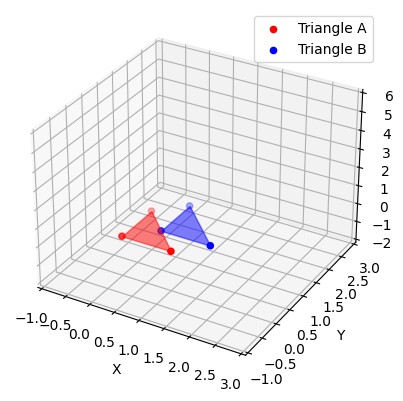

ok
test_bounding_box_non_intersecting (__main__.TestTriangleIntersection) ... 

Visualizing test case: Bounding Box Non-Intersecting


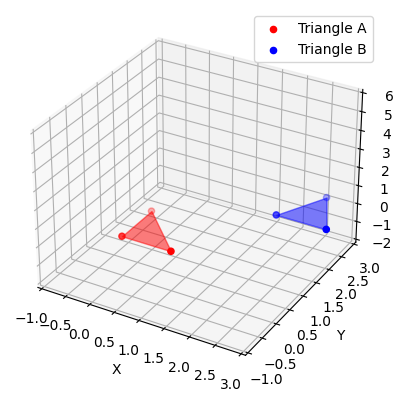

ok
test_coplanar_intersecting (__main__.TestTriangleIntersection) ... 

Visualizing test case: Coplanar Intersecting


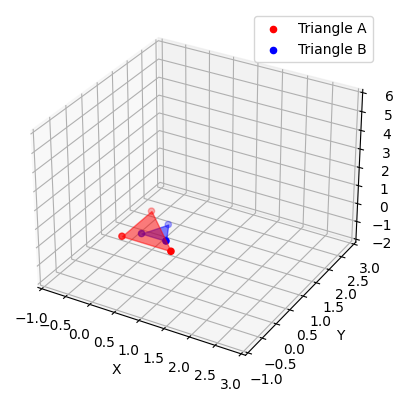

ok
test_coplanar_non_intersecting (__main__.TestTriangleIntersection) ... 

Visualizing test case: Coplanar Non-Intersecting


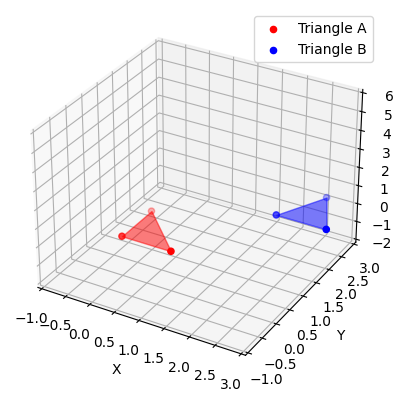

ok
test_degenerate_triangle_non_intersecting (__main__.TestTriangleIntersection) ... 

Visualizing test case: Degenerate Non-Intersecting


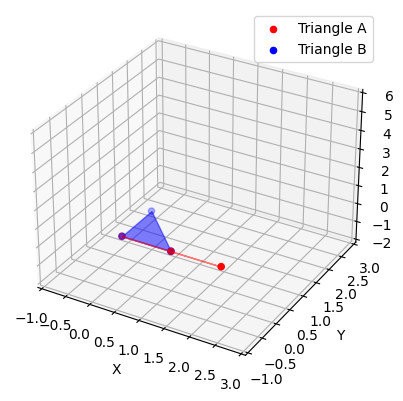

ok
test_degenerate_triangle_with_non_degenerate (__main__.TestTriangleIntersection) ... 

Visualizing test case: Degenerate with Non-Degenerate


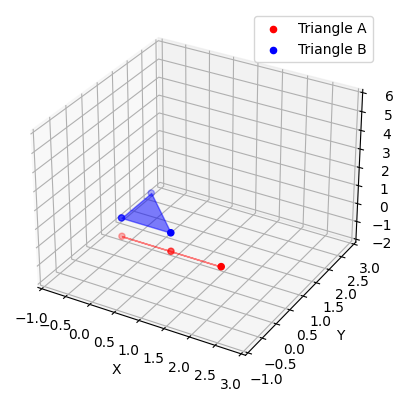

ok
test_edge_edge_intersection (__main__.TestTriangleIntersection) ... 

Visualizing test case: Edge-Edge Intersection


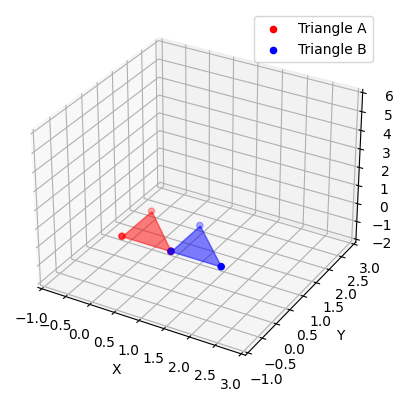

ok
test_intersecting (__main__.TestTriangleIntersection) ... 

Visualizing test case: Intersecting


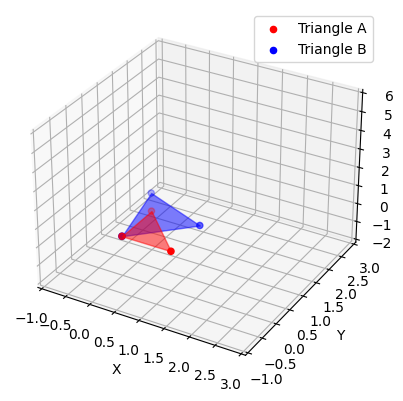

ok
test_non_coplanar_intersecting (__main__.TestTriangleIntersection) ... 

Visualizing test case: Non-Coplanar Intersecting


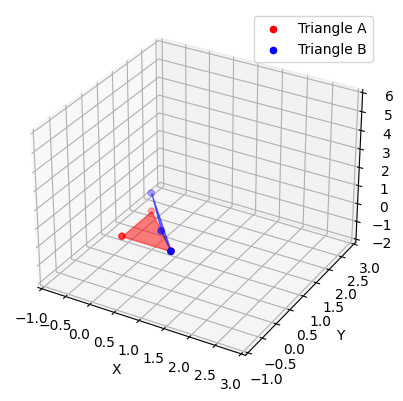

ok
test_non_intersecting (__main__.TestTriangleIntersection) ... 

Visualizing test case: Non-Intersecting


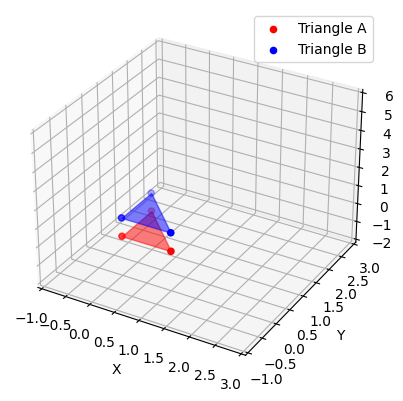

ok
test_cross_product (__main__.TestVector3D) ... ok
test_dot_product (__main__.TestVector3D) ... ok
test_magnitude (__main__.TestVector3D) ... ok
test_normalize (__main__.TestVector3D) ... ok

----------------------------------------------------------------------
Ran 14 tests in 1.705s

OK


In [39]:
import unittest


class TestTriangleIntersection(unittest.TestCase):
    def setUp(self):
        # Create reusable test triangles
        self.triangle1 = Triangle(Vector3D(0, 0, 0), Vector3D(1, 0, 0), Vector3D(0, 1, 0))
        self.triangle2 = Triangle(Vector3D(0, 0, 1), Vector3D(1, 0, 1), Vector3D(0, 1, 1))
        self.triangle3 = Triangle(Vector3D(0.5, 0.5, 0), Vector3D(0.5, 0.5, 1), Vector3D(0.5, 0.7, 0.5))
        self.triangle4 = Triangle(Vector3D(0, 0, 0), Vector3D(1, 1, 0), Vector3D(0, 1, 1))

        self.coplanar_triangle = Triangle(Vector3D(0.25, 0.25, 0), Vector3D(0.75, 0.25, 0), Vector3D(0.5, 0.75, 0))
        self.non_coplanar_intersecting_triangle = Triangle(Vector3D(0.5, 0.5, 0), Vector3D(1, 0, 0), Vector3D(0, 1, 1))

        # Degenerate triangles (collinear points)
        self.degenerate_triangle1 = Triangle(Vector3D(0, 0, 0), Vector3D(1, 0, 0), Vector3D(2, 0, 0))  # Collinear points

        # Edge-edge intersection triangles
        self.edge_edge_triangle1 = Triangle(Vector3D(0, 0, 0), Vector3D(1, 0, 0), Vector3D(0, 1, 0))
        self.edge_edge_triangle2 = Triangle(Vector3D(1, 0, 0), Vector3D(2, 0, 0), Vector3D(1, 1, 0))

        # Bounding box cases
        self.bounding_box_triangle1 = Triangle(Vector3D(0, 0, 0), Vector3D(1, 0, 0), Vector3D(0, 1, 0))
        self.bounding_box_triangle2 = Triangle(Vector3D(0.5, 0.5, 0), Vector3D(1.5, 0.5, 0), Vector3D(0.5, 1.5, 0))

    def visualize_test_case(self, triangle_a, triangle_b, case_name):
        print(f"Visualizing test case: {case_name}")
        tri_a_points = [(v.x, v.y, v.z) for v in [triangle_a.p1, triangle_a.p2, triangle_a.p3]]
        tri_b_points = [(v.x, v.y, v.z) for v in [triangle_b.p1, triangle_b.p2, triangle_b.p3]]
        visualize_triangles(tri_a_points, tri_b_points)

    def test_degenerate_triangle_non_intersecting(self):
        self.visualize_test_case(self.degenerate_triangle1, self.triangle1, "Degenerate Non-Intersecting")
        self.assertFalse(self.degenerate_triangle1.intersect(self.triangle1))

    def test_degenerate_triangle_with_non_degenerate(self):
        self.visualize_test_case(self.degenerate_triangle1, self.triangle2, "Degenerate with Non-Degenerate")
        self.assertFalse(self.degenerate_triangle1.intersect(self.triangle2))

    def test_edge_edge_intersection(self):
        self.visualize_test_case(self.edge_edge_triangle1, self.edge_edge_triangle2, "Edge-Edge Intersection")
        self.assertTrue(self.edge_edge_triangle1.intersect(self.edge_edge_triangle2))

    def test_bounding_box_intersecting(self):
        self.visualize_test_case(self.bounding_box_triangle1, self.bounding_box_triangle2, "Bounding Box Intersecting")
        self.assertTrue(self.bounding_box_triangle1.intersect(self.bounding_box_triangle2))

    def test_bounding_box_non_intersecting(self):
        triangle5 = Triangle(Vector3D(2, 2, 0), Vector3D(3, 2, 0), Vector3D(2.5, 3, 0))
        self.visualize_test_case(self.bounding_box_triangle1, triangle5, "Bounding Box Non-Intersecting")
        self.assertFalse(self.bounding_box_triangle1.intersect(triangle5))

    def test_non_intersecting(self):
        self.visualize_test_case(self.triangle1, self.triangle2, "Non-Intersecting")
        self.assertFalse(self.triangle1.intersect(self.triangle2))

    def test_intersecting(self):
        self.visualize_test_case(self.triangle1, self.triangle4, "Intersecting")
        self.assertTrue(self.triangle1.intersect(self.triangle4))

    def test_coplanar_intersecting(self):
        self.visualize_test_case(self.triangle1, self.coplanar_triangle, "Coplanar Intersecting")
        self.assertTrue(self.triangle1.intersect(self.coplanar_triangle))

    def test_coplanar_non_intersecting(self):
        triangle4 = Triangle(Vector3D(2, 2, 0), Vector3D(3, 2, 0), Vector3D(2.5, 3, 0))
        self.visualize_test_case(self.triangle1, triangle4, "Coplanar Non-Intersecting")
        self.assertFalse(self.triangle1.intersect(triangle4))
        
    def test_non_coplanar_intersecting(self):
        self.visualize_test_case(self.triangle1, self.non_coplanar_intersecting_triangle, "Non-Coplanar Intersecting")
        self.assertTrue(self.triangle1.intersect(self.non_coplanar_intersecting_triangle))


if __name__ == '__main__':
    unittest.main(argv=[''], verbosity=3, exit=False)